# Introduction to Semantic Segmentation

## What is Semantic Segmentation?

Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class. <br/>

Similar to what us humans do all the time by default, when are looking then whatever we are seeing if we think of that as an image
then we know what class each pixel of the image belongs to.

Essentially, Semantic Segmentation is the technique through which we can achieve this in Computers.

There are a few more types of Segmentation, you can read about it more here: https://www.learnopencv.com/image-segmentation/
This lab will focus on Semantic Segmentation where each pixel in the image is classified to its respective class.

This is in most simple terms what Semantic Segmentation is.

## Applications of Segmentation


The most common use case for the Semantic Segmentation is in:

1. **Autonomous Driving**

  <img src="https://cdn-images-1.medium.com/max/1600/1*JKmS08bllQ8SCajIPyiBBQ.png" width="400"/> <br/>
  
  In autonomous driving, the image which comes in from the camera is semantically segmented, thus each pixel in the image is classified
  into a class. This helps the computer understand what is present in the its surroundings and thus helps the car act accordingly.


2. **Facial Segmentation**

  <img src="https://i.ytimg.com/vi/vrvwfFej_r4/maxresdefault.jpg" width="400"/> <br/>

  Facial Segmentation is used for segmenting each part of the face into a category, like lips, eyes etc. This technique is used for
  many purposes such as gender estimation, age estimation, facial expression analysis, emotional analysis and more.
  

3. **Indoor Object Segmentation**

  Guess where is this used? In AR (Augmented Reality) and VR (Virtual Reality). AR applications when required segments the entire indoor area to understand where there
  are chairs, tables, people, wall, and other obstacles and so on.


4. **Geo-Land Sensing**

  <img src="https://ars.els-cdn.com/content/image/1-s2.0-S0924271616305305-fx1_lrg.jpg" width="400"/> <br/>

  Geo Land Sensing is a way of categorizing each pixel in satellite images into a category such that we can track the land cover of each
  area. So, say in some area there is a heavy deforestation taking place then appropriate measures can be taken.


## Using torchvision for Semantic Segmentation

Now before we get started, we need to know about the inputs and outputs of these semantic segmentation models.<br/>
So, let's start!

These models expect a 3-channled image which is normalized with the Imagenet mean and standard deviation, i.e., <br/>
`mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

So, the input is `[Ni x Ci x Hi x Wi]`<br/>
where,
- `Ni` -> the batch size
- `Ci` -> the number of channels (which is 3)
- `Hi` -> the height of the image
- `Wi` -> the width of the image

And the output of the model is `[No x Co x Ho x Wo]`<br/>
where,
- `No` -> is the batch size (same as `Ni`)
- `Co` -> **is the number of classes that the dataset have!**
- `Ho` -> the height of the image (which is the same as `Hi` in almost all cases)
- `Wo` -> the width of the image (which is the same as `Wi` in almost all cases)

Alright! And just one more thing!
The `torchvision` models outputs an `OrderedDict` and not a `torch.Tensor` <br/>
And in `.eval()` mode it just has one key `out` and thus to get the output we need to get the value
stored in that `key`.

The `out` key of this `OrderedDict` is the key that holds the output. <br/>
So, this `out` key's value has the shape of `[No x Co x Ho x Wo]`.

Now! we are ready to play :)

### FCN with Resnet-101 backbone

FCN - Fully Convolutional Netowrks, are among the most early invented Neural Networks for the task of Semantic Segmentation.

Let's load one up!

In [9]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:01<00:00, 168MB/s]


And that's it we have a pretrained model of `FCN` (which stands for Fully Convolutional Neural Networks) with a `Resnet101` backbone :)

Now, let's get an image!

2025-04-08 09:54:21 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182904/182904] -> "bird.png" [1]


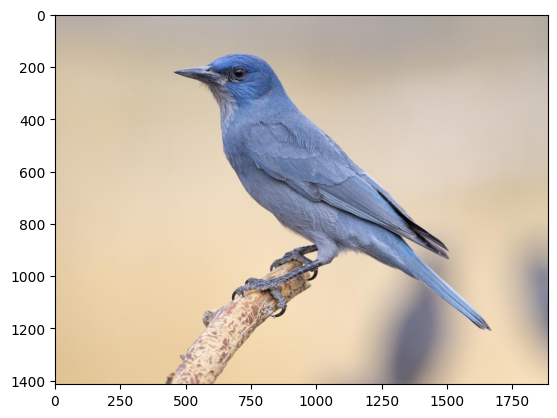

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

Now, that we have the image we need to preprocess it and normalize it! <br/>
So, for the preprocessing steps, we:
- Resize the image to `(256 x 256)`
- CenterCrop it to `(224 x 224)`
- Convert it to Tensor - all the values in the image becomes between `[0, 1]` from `[0, 255]`
- Normalize it with the Imagenet specific values `mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

And lastly, we unsqueeze the image so that it becomes `[1 x C x H x W]` from `[C x H x W]` <br/>
We need a batch dimension while passing it to the models.

In [11]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

Let's see what the above code cell does </br>
`T.Compose` is a function that takes in a `list` in which each element is of `transforms` type and </br>
it returns a object through which we can
pass batches of images and all the required transforms will be applied to the images.

Let's take a look at the transforms applied on the images:
- `T.Resize(256)` : Resizes the image to size `256 x 256`
- `T.CenterCrop(224)` : Center Crops the image to have a resulting size of `224 x 224`
- `T.ToTensor()` : Converts the image to type `torch.Tensor` and have values between `[0, 1]`
- `T.Normalize(mean, std)` : Normalizes the image with the given mean and standard deviation.

Alright! Now that we have the image all preprocessed and ready! Let's pass it through the model and get the `out` key.<br/>
As I said, the output of the model is a `OrderedDict` so, we need to take the `out` key from that to get the output of the model.

In [12]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


Alright! So, `out` is the final output of the model. And as we can see, its shape is `[1 x 21 x H x W]` as discussed earlier. So, the model was trained on `21` classes and thus our output have `21` channels!<br/>

Now, what we need to do is make this `21` channeled output into a `2D` image or a `1` channeled image, where each pixel of that image corresponds to a class!

So, the `2D` image, (of shape `[H x W]`) will have each pixel corresponding to a class label, and thus <br/>
for each `(x, y)` in this `2D` image will correspond to a number between `0 - 20` representing a class.

And how do we get there from this `[1 x 21 x H x W]`?<br/>
We take a max index for each pixel position, which represents the class<br/>

In [13]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[0 3]


Alright! So, we as we can see now have a `2D` image. Where each pixel corresponds to a class!
The last thing is to take this `2D` image where each pixel corresponds to a class label and convert this<br/>
into a segmentation map where each class label is converted into a `RGB` color and thus helping in easy visualization.

We will use the following function to convert this `2D` image to an `RGB` image wheree each label is mapped to its
corresponding color.

In [14]:
# Define the helper function
def decode_segmap(image, nc=21):

  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

Let's see what we are doing inside this function!

first `label_colors` stores the colors for each of the clases, according to the index </br>
So, the color for the  first class which is `background` is stored in the `0`th index of the `label_colors` list,
the second class which is `aeroplane` is stored at index `1` of `label_colors`.

Now, we are to create an `RGB` image from the `2D` image passed. So, what we do, is we create empty `2D` matrices for all 3 channels.

So, `r`, `g`, and `b` are arrays which will form the `RGB` channels for the final image. And each are of shape `[H x W]`
(which is same as the shape of `image` passed in)

Now, we loop over each class color we stored in `label_colors`.
And we get the indexes in the image where that particular class label is present. (`idx = image == l`)
And then for each channel, we put its corresponding color to those pixels where that class label is present.

And finally we stack the 3 seperate channels to form a `RGB` image.

Okay! Now, let's use this function to see the final segmented output!

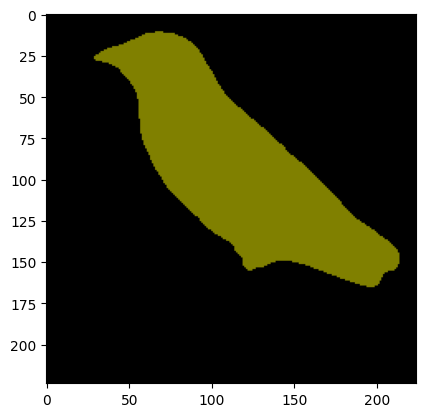

In [15]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

And there we go!!<br/>
We have segmented the output of the image.

That's the bird!

Also, Do note that the image after segmentation is smaller than the original image as in the preprocessing step the image is resized and cropped.

Next, let's move all this under one function and play with a few more images!

In [16]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640),
                   #T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

And let's get a new image!

2025-04-08 09:54:41 URL:http://learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg [128686/128686] -> "horse.png" [1]


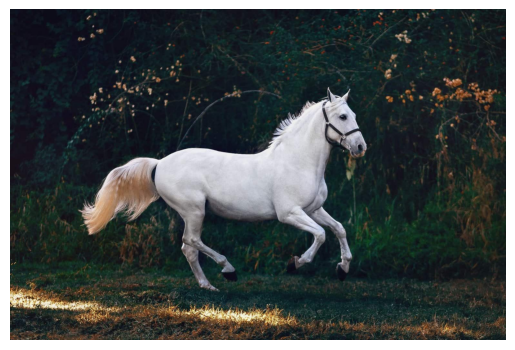

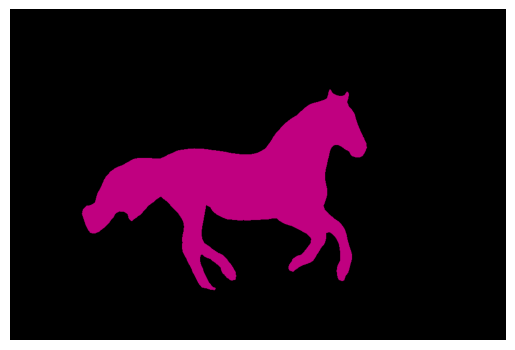

In [17]:
!wget -nv https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg -O horse.png
segment(fcn, './horse.png')

### DeepLabv3

In [18]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Alright! Now we have god-level segmentation model!<br/>
Let's see how we perform with the same image on this model!

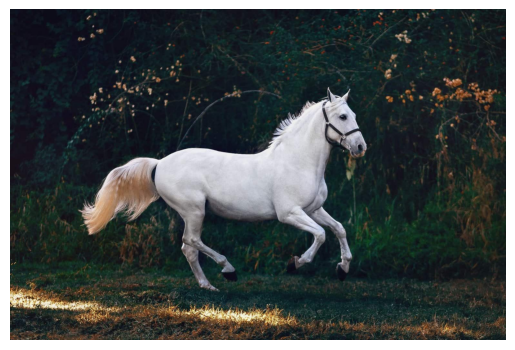

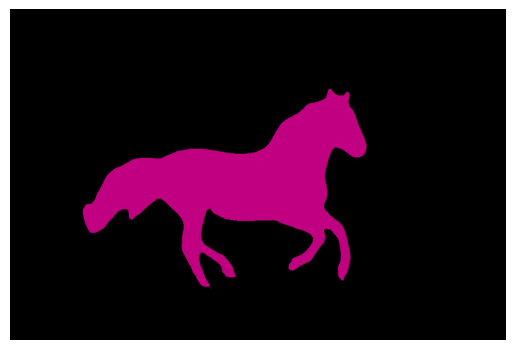

In [19]:
segment(dlab, './horse.png')

Yeah! So, there you go! You can see that, the DeepLab model has also classified the image quite nicely! </br>
But if we take a more complex image! Then we start to see model differences!

Note: As we saw before the output image size is smaller than the original image as the original image is resized and cropped in the preprocessing step.

Let's try that out!

2025-04-08 09:54:53 URL:http://learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg [95431/95431] -> "person.png" [1]


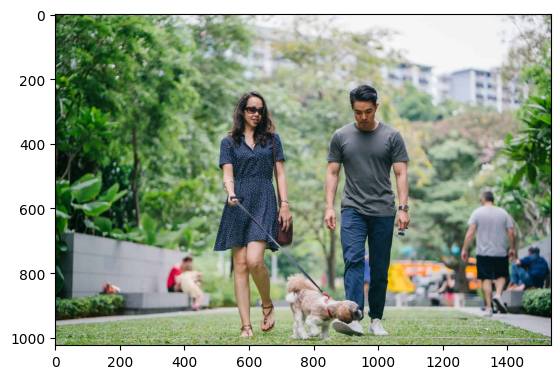

Segmenatation Image on FCN


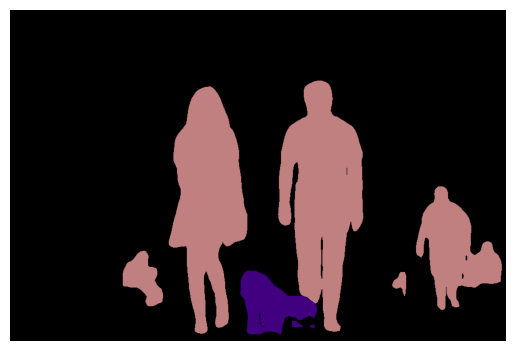

Segmenatation Image on DeepLabv3


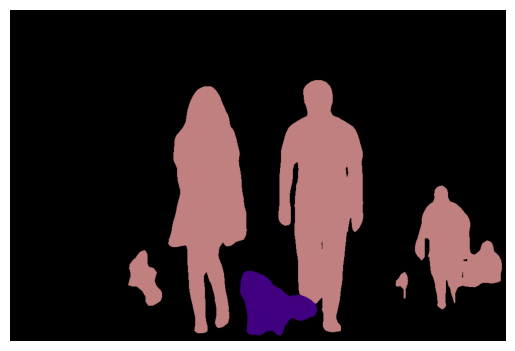

In [20]:
!wget -nv "https://www.learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg" -O person.png
img = Image.open('./person.png')
plt.imshow(img); plt.show()

print ('Segmenatation Image on FCN')
segment(fcn, path='./person.png', show_orig=False)

print ('Segmenatation Image on DeepLabv3')
segment(dlab, path='./person.png', show_orig=False)

Okay! You can now see the model differences right?

You can see how FCN fails to capture the continuity of the leg of the cow while DeepLabv3 is able to capture that!

Also, if we look closer into the hand of the human which is on the cow, we can see that the FCN model captures it nicely, not very nicely, but still, while the DeepLabv3 model has captured it too but not that well!

These are a few model differences that be noticed with bare eyes!

Note: As we saw before the output image size is smaller than the original image as the original image is resized and cropped in the preprocessing step.

Do play around with a few more images to see how these models perform in different scenarios.!

#**Task 01**

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.WIIEMT_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.WIIEMT_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


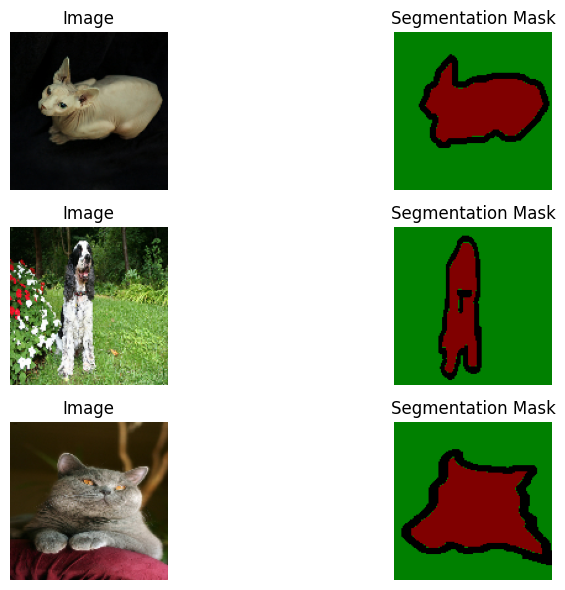

In [21]:
# *************************************************
# TASK 1 - UNDERSTANDING SEMANTIC SEGMENTATION DATA
# *************************************************

# Try to understand what semantic segmentation data looks like. Load a small semantic
# segmentation dataset (Pascal VOC, Oxford Pet). Visualize a few image–mask pairs. Use
# color mapping to show different classes.

# WRITE YOUR CODE HERE

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Load Oxford-IIIT Pet Dataset
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)
train_ds = dataset['train']

# Define a function to preprocess the images and masks
def preprocess(datapoint):
    image = tf.image.resize(datapoint['image'], (128, 128))
    mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize image
    mask = tf.cast(mask, tf.uint8)
    return image, mask

# Preprocess the dataset
train_ds = train_ds.map(preprocess).batch(1)

# Color map for visualization
def create_colormap(mask):
    colormap = tf.constant([
        [0, 0, 0],       # Class 0: background
        [128, 0, 0],     # Class 1: foreground (pet)
        [0, 128, 0],     # Class 2: outline
    ])

    mask = tf.squeeze(mask)
    mask = tf.cast(mask, tf.int32)
    return tf.gather(colormap, mask)


# Visualize a few samples
plt.figure(figsize=(10, 6))
for i, (images, masks) in enumerate(train_ds.take(3)):
    image = images[0]
    mask = masks[0]
    mask_color = create_colormap(mask)

    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(mask_color)
    plt.title("Segmentation Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

# *************************************************
# *************************************************

## Comparision

For, now we will see how these two models compare with each other in 3 metrics
- Inference time
- Size of the model
- GPU memory used by the model

### Inference Time

In [22]:
import time

def infer_time(net, path='./horse.png', dev='cuda'):
  img = Image.open(path)
  trf = T.Compose([T.Resize(256),
                   T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])

  inp = trf(img).unsqueeze(0).to(dev)

  st = time.time()
  out1 = net.to(dev)(inp)
  et = time.time()

  return et - st

#### On CPU

In [23]:
avg_over = 100

fcn_infer_time_list_cpu = [infer_time(fcn, dev='cpu') for _ in range(avg_over)]
fcn_infer_time_avg_cpu = sum(fcn_infer_time_list_cpu) / avg_over

dlab_infer_time_list_cpu = [infer_time(dlab, dev='cpu') for _ in range(avg_over)]
dlab_infer_time_avg_cpu = sum(dlab_infer_time_list_cpu) / avg_over
print ('The Average Inference time on FCN is:     {:.2f}s'.format(fcn_infer_time_avg_cpu))
print ('The Average Inference time on DeepLab is: {:.2f}s'.format(dlab_infer_time_avg_cpu))

The Average Inference time on FCN is:     1.83s
The Average Inference time on DeepLab is: 1.93s


#### On GPU

In [24]:
avg_over = 100

fcn_infer_time_list_gpu = [infer_time(fcn) for _ in range(avg_over)]
fcn_infer_time_avg_gpu = sum(fcn_infer_time_list_gpu) / avg_over

dlab_infer_time_list_gpu = [infer_time(dlab) for _ in range(avg_over)]
dlab_infer_time_avg_gpu = sum(dlab_infer_time_list_gpu) / avg_over

print ('The Average Inference time on FCN is:     {:.3f}s'.format(fcn_infer_time_avg_gpu))
print ('The Average Inference time on DeepLab is: {:.3f}s'.format(dlab_infer_time_avg_gpu))

The Average Inference time on FCN is:     0.024s
The Average Inference time on DeepLab is: 0.039s


### Model Size

In [29]:
import os

# Correct filenames based on your Colab output
resnet_file = '/root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth'
fcn_file = '/root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth'
dlab_file = '/root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth'

# Check sizes
resnet101_size = os.path.getsize(resnet_file)
fcn_size = os.path.getsize(fcn_file)
dlab_size = os.path.getsize(dlab_file)

# Calculate total sizes
fcn_total = fcn_size + resnet101_size
dlab_total = dlab_size + resnet101_size

# Print in MB
print('Size of the FCN model with ResNet101 backbone is:       {:.2f} MB'.format(fcn_total / (1024 * 1024)))
print('Size of the DeepLabv3 model with ResNet101 backbone is: {:.2f} MB'.format(dlab_total / (1024 * 1024)))


Size of the FCN model with ResNet101 backbone is:       378.22 MB
Size of the DeepLabv3 model with ResNet101 backbone is: 403.73 MB


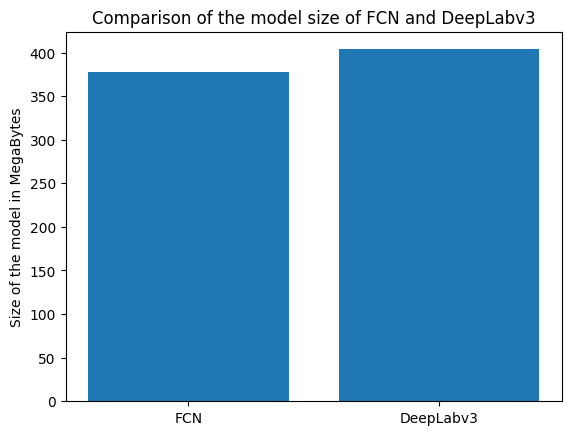

In [30]:
plt.bar([0, 1], [fcn_total / (1024 * 1024), dlab_total / (1024 * 1024)])
plt.ylabel('Size of the model in MegaBytes')
plt.xticks([0, 1], ['FCN', 'DeepLabv3'])
plt.title('Comparison of the model size of FCN and DeepLabv3')
plt.show()

##**Task 02**


Processing: /content/chair.JPG


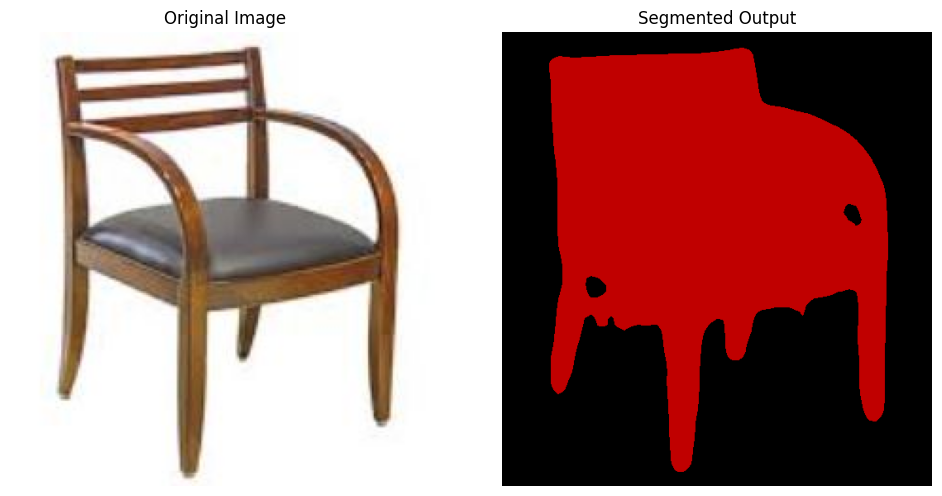

Processing: /content/bus.JPG


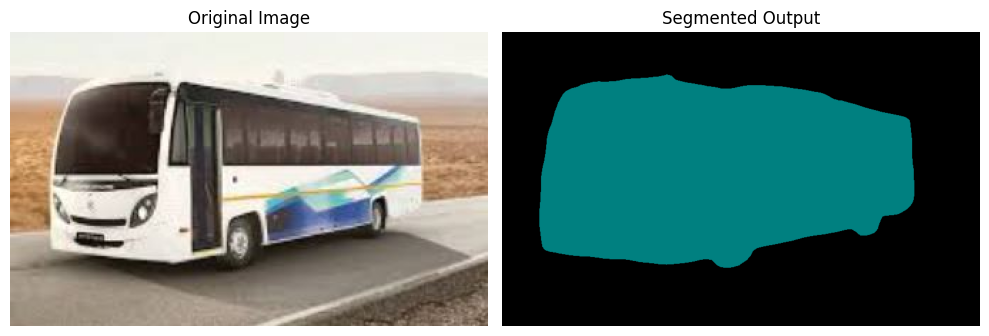

In [8]:
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Mount Google Drive if needed (optional)
# from google.colab import drive
# drive.mount('/content/drive')

# Load pre-trained DeepLabV3+ model
model = deeplabv3_resnet101(pretrained=True)
model.eval()

# Preprocessing for DeepLabV3+
preprocess = T.Compose([
    T.Resize(520),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

# Decode segmentation map into color image
def decode_segmap(segmentation):
    label_colors = np.array([
        (0, 0, 0),       # 0=background
        (128, 0, 0),     # 1
        (0, 128, 0),     # 2
        (128, 128, 0),   # 3
        (0, 0, 128),     # 4
        (128, 0, 128),   # 5
        (0, 128, 128),   # 6
        (128, 128, 128), # 7
        (64, 0, 0),      # 8
        (192, 0, 0),     # 9
        # Add more as needed...
    ])
    r = np.zeros_like(segmentation).astype(np.uint8)
    g = np.zeros_like(segmentation).astype(np.uint8)
    b = np.zeros_like(segmentation).astype(np.uint8)

    for l in range(len(label_colors)):
        idx = segmentation == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

# Inference and visualization
def segment_and_display_local(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    output_predictions = output.argmax(0)
    seg_image = decode_segmap(output_predictions.numpy())

    # Show original and segmented images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Segmented Output")
    plt.imshow(seg_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# List of image file names (uploaded in Colab's working directory)
uploaded_image_paths = [
    '/content/chair.JPG',
    '/content/bus.JPG',
    # Add more if needed
]

# Run inference
for img_path in uploaded_image_paths:
    if os.path.exists(img_path):
        print(f"Processing: {img_path}")
        segment_and_display_local(img_path)
    else:
        print(f"File not found: {img_path}")


### **Description of Task 01**

This code demonstrates how semantic segmentation data works by using the *Oxford-IIIT Pet Dataset*, which includes paired images and pixel-level segmentation masks. Here's what each part does:

- **Dataset Loading:**  The Oxford Pet dataset is loaded via tensorflow_datasets (tfds), which provides both pet images and their annotated segmentation masks.

- **Preprocessing:**  Each image and mask is resized to 128x128 pixels for consistency and normalized (for images) or cast to uint8 (for masks).

- **Color Mapping Function:** A custom colormap is applied to convert class labels in the segmentation masks to visually distinguishable RGB colors:
  - Class 0 (Background) → Black
  - Class 1 (Pet) → Dark Red
  - Class 2 (Outline) → Green

- **Visualization:**  
  Three image–mask pairs are displayed in a side-by-side format using matplotlib, where each original image is followed by its color-coded segmentation mask.

---

### **Conclusion & Interpretation of Output**

The output clearly shows that:
- Semantic segmentation masks accurately identify the pet's region (foreground) in the images by filling it with a dark red color.
- Outlines are marked in green, helping to distinguish the pet's boundaries from the background.
- Background areas remain black, indicating non-pet regions.

This visual evidence confirms that the dataset is structured properly for semantic segmentation tasks, and the model (or human interpreter) can easily distinguish between different object classes in the image at a pixel level. It serves as a solid foundation for training or evaluating segmentation models like DeepLabV3+.

### **Description of Task 02**

The code applies a pre-trained DeepLabV3+ model (ResNet-101 backbone) from PyTorch to perform *semantic segmentation* on custom images. It follows these steps:

1. **Model Loading**: Loads deeplabv3_resnet101 with pre-trained weights.
2. **Image Preprocessing**: Resizes images to 520 pixels, normalizes with ImageNet stats, and converts them to tensors.
3. **Inference**: Passes the image through the model to get segmentation logits, then takes argmax to obtain class predictions for each pixel.
4. **Decoding**: Maps class labels to RGB colors using a custom colormap (decode_segmap).
5. **Visualization**: Displays the original image alongside the segmented output using matplotlib.

---

### **Understanding the Output**

From the results:
- The **chair image** is accurately segmented, where the model identifies the shape of the chair and marks it with a distinct color, separating it from the background.
- In the **bus image**, the bus is completely masked with a single color, showing that the model successfully recognized it as one cohesive object class (likely "bus" or "vehicle" depending on training labels).

These results demonstrate that the DeepLabV3+ model is effectively capturing and segmenting the *main object classes* in diverse real-world images. The output masks are clean, with good alignment to object boundaries, validating the model’s understanding of scene content.